In [93]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import heapq

## 1. Implementation of PCA

### dataset.py

In [94]:
def generate_plane(d=2, dim=3, classes=2):
    data = np.random.randn(100, d)  # Generate 100 points with d features each
    
    # Random transformation matrix
    transformation_matrix = np.random.randn(d, dim)
    
    # Project data onto the `dim`-dimensional space
    data = np.dot(data, transformation_matrix)

    # Step 2: Add Gaussian noise to the data
    noise = np.random.randn(data.shape[0], dim) * 0.1
    data += noise
    
    step_size = data[:, 0].max() / classes  # Divide the first dimension into `classes` parts
    
    labels = np.digitize(data[:, 0], bins=np.linspace(data[:, 0].min(), data[:, 0].max(), classes+1)) - 1
    
    return data, labels


def load_dataset(path):
    dataset = np.load(path)
    return dataset['data'], dataset['target']


### pca.py

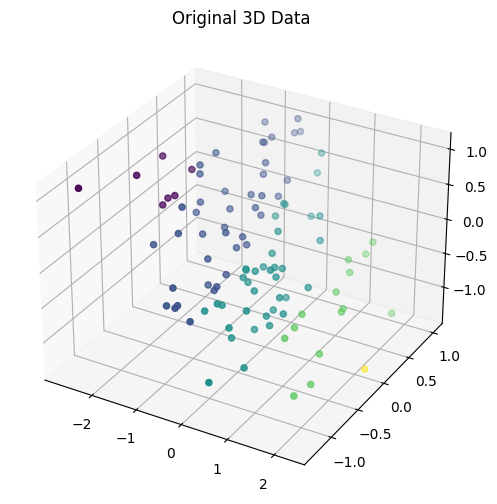

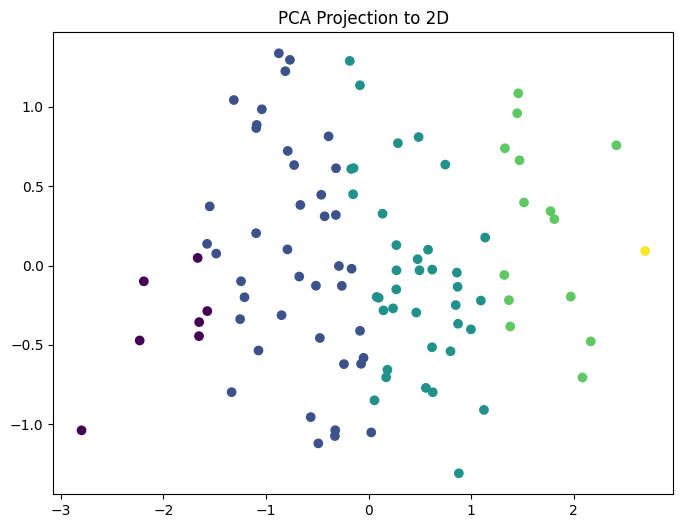

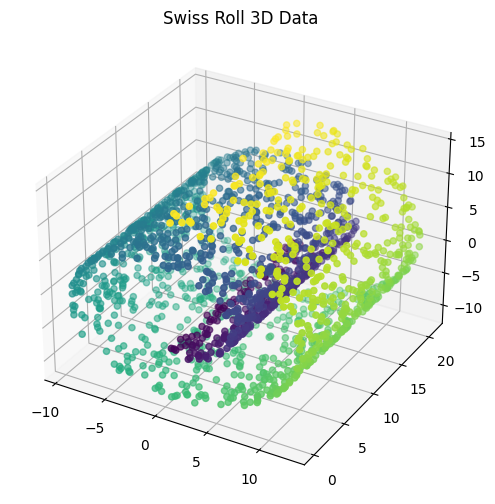

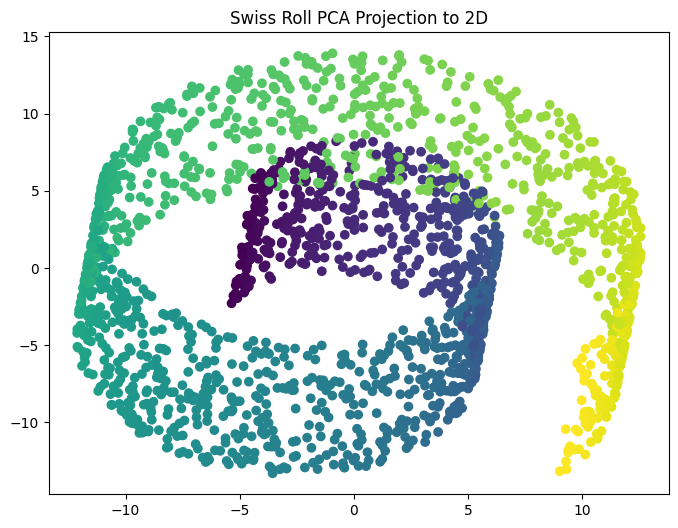

In [95]:
# ______________________________1.1. Implement the algorithm______________________________
class PCA:

    def __init__(self, n_components):
        """
        Initialize PCA with the number of components to retain
        """
        self.n_components = n_components
        self.mean = None
        self.components = None
        self.explained_variance_ratio_ = None
    
    def _center_data(self, X):
        """Center the data by subtracting the mean"""
        self.mean = np.mean(X, axis=0)
        return X - self.mean
    
    def _create_cov(self, X):
        """Compute the covariance matrix [X^T * X]/N-1"""
        return (X.T @ X) / (X.shape[0] -1)
    
    def _power_iteration(self, A, num_simulations=100):
        """Approximate the dominant eigenvector and eigenvalue [v^T * A * v] = λ"""
        b_k = np.random.rand(A.shape[1])
        for _ in range(num_simulations):
            b_k1 = np.dot(A, b_k)
            b_k1_norm = np.sqrt(np.sum(b_k1 ** 2))
            b_k = b_k1 / b_k1_norm
        eigenvalue = np.dot(b_k.T, np.dot(A, b_k))
        return eigenvalue, b_k
    
    def _decompose(self, covariance_matrix):
        """Compute eigenvalues and eigenvectors using power iteration [A = A - λv * v^T]"""
        eigenvalues = []
        eigenvectors = []
        A = np.copy(covariance_matrix)
        for _ in range(self.n_components):
            eigenvalue, eigenvector = self._power_iteration(A)
            eigenvalues.append(eigenvalue)
            eigenvectors.append(eigenvector)
            A -= eigenvalue * np.outer(eigenvector, eigenvector)
        return np.array(eigenvalues), np.array(eigenvectors).T
    
    def fit(self, X):
        """Fit the PCA model to the dataset"""
        X_centered = self._center_data(X)
        covariance_matrix = self._create_cov(X_centered)
        eigenvalues, eigenvectors = self._decompose(covariance_matrix)

        total_variance = np.sum(eigenvalues)
        self.explained_variance_ratio_ = eigenvalues[:self.n_components] / total_variance

        self.components = eigenvectors[:, :self.n_components]
    
    def transform(self, X):
        """Project the data onto the top principal components"""
        X_centered = X - self.mean
        return X_centered @ self.components
    
    def fit_transform(self, X):
        """Fit PCA and transform the data."""
        self.fit(X)
        return self.transform(X)
    
    def inverse_transform(self, X_transformed):
        """Reconstruct the original data from the transformed data."""
        return X_transformed @ self.components.T + self.mean


# ______________________________1.2. Test on linear data______________________________
if __name__ == "__main__":
    # Generate linear plane dataset
    X, y = generate_plane(d=2, dim=3, classes=4)
    
    # Visualizing the 3D plane
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis')
    plt.title("Original 3D Data")
    plt.show()
    
    # Apply PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # Visualizing 2D projection
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
    plt.title("PCA Projection to 2D")
    plt.show()
    
# ______________________________1.3. Test on swiss roll______________________________

    # Load Swiss Roll dataset
    X_swiss, _ = load_dataset("datasets/swissroll.npz")
    
    # Visualizing Swiss Roll in 3D
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=_)
    plt.title("Swiss Roll 3D Data")
    plt.show()
    
    # Apply PCA to Swiss Roll
    X_swiss_pca = pca.fit_transform(X_swiss)
    
    # Visualizing PCA Projection of Swiss Roll
    plt.figure(figsize=(8, 6))
    plt.scatter(X_swiss_pca[:, 0], X_swiss_pca[:, 1], c=_)
    plt.title("Swiss Roll PCA Projection to 2D")
    plt.show()

## 2. Implementation of Isomap

### geo.py

In [96]:
# ______________________________2.2. Compute geodesic graph______________________________

def _compute_distance_matrix(X):
    """ d_i_j^2 = ||x_i - x_j||^2 = ||x_i||^2 + ||x_j||^2 - 2 * x_i^T * x_j """
    sum_X2 = np.sum(np.square(X), axis=1, keepdims=True) # m x 1
    distance_matrix = sum_X2 + sum_X2.T - 2 * np.dot(X, X.T)
    distance_matrix = np.maximum(distance_matrix, 0) # remove negative values
    return np.sqrt(distance_matrix)


# ______________________________2.1. Calculate pairwise distances______________________________

class KNearestNeighbors:
    def __init__(self, k):
        self.k = k
    
    def __call__(self, X):

        distance_matrix = _compute_distance_matrix(X)
        
        m = X.shape[0]
        adjacency_matrix = np.zeros((m, m))
        
        for i in range(m):
            nearest_neighbors = np.argsort(distance_matrix[i])[:self.k + 1]  # +1 to exclude the point itself
            adjacency_matrix[i, nearest_neighbors] = 1  # Set these as neighbors 1
            adjacency_matrix[nearest_neighbors, i] = 1  # Make it symmetric
        
        return adjacency_matrix
    

class EpsNeighborhood:
    
    def __init__(self, eps):
        self.epsilon = eps
    
    def __call__(self, X):

        distance_matrix = _compute_distance_matrix(X)
        
        m = X.shape[0]
        adjacency_matrix = np.zeros((m, m))
        
        for i in range(m):
            neighbors_within_eps = np.where(distance_matrix[i] <= self.epsilon)[0]  # Indices of points within epsilon distance
            adjacency_matrix[i, neighbors_within_eps] = 1  # Set these as neighbors 1
            adjacency_matrix[neighbors_within_eps, i] = 1  # Make it symmetric
        
        return adjacency_matrix

### isomap.py

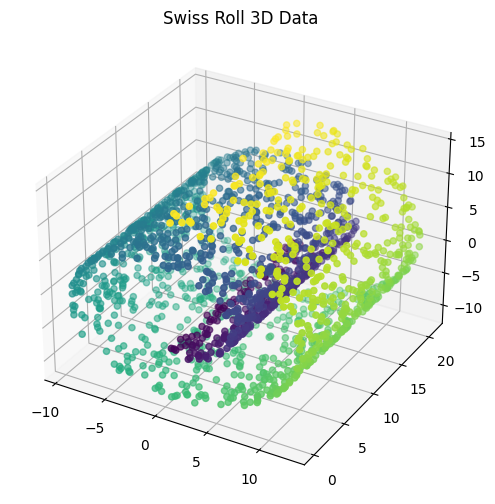

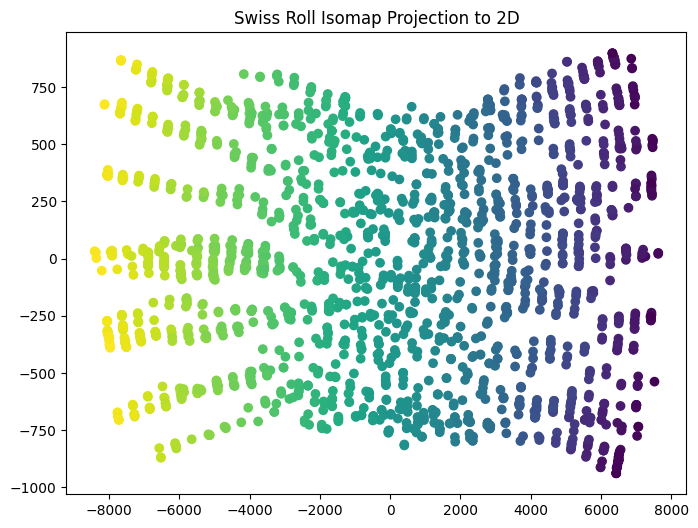

In [115]:
# ______________________________2.2. Compute geodesic graph______________________________

class Isomap:
    def __init__(self, n_components, *, adj_calculator=KNearestNeighbors(20)):
        self.n_components = n_components
        self._adj_calculator = adj_calculator
        self._decomposer = PCA(n_components=n_components)

    def _compute_geodesic_distances(self, X):
        adjacency_matrix = self._adj_calculator(X)
        m = X.shape[0]
        geodesic_distances = np.full((m, m), np.inf)

        for i in range(m):
            geodesic_distances[i] = self._dijkstra(adjacency_matrix, i)

        return geodesic_distances

    def _dijkstra(self, adjacency_matrix, src):
        """Uding heap priority queue with O(E+VlogV) instead of O(V^2) for normal list"""
        m = adjacency_matrix.shape[0]
        distances = np.full(m, np.inf)
        distances[src] = 0

        # Priority queue (min-heap) to hold nodes with the smallest distance
        heap = [(0, src)]  # (distance, node)

        while heap:
            current_dist, min_index = heapq.heappop(heap)

            # If the processed distance is greater than the recorded value, skip it
            if current_dist > distances[min_index]:
                continue

            # Check neighbors
            for neighbor in range(m):
                if adjacency_matrix[min_index, neighbor] > 0:
                    new_dist = distances[min_index] + adjacency_matrix[min_index, neighbor]
                    if new_dist < distances[neighbor]:
                        distances[neighbor] = new_dist
                        heapq.heappush(heap, (new_dist, neighbor))

        return distances


# ______________________________2.3. Apply PCA to the graph______________________________

    def _decompose(self, geodesic_distances):
        """Convert distance matrix to Gram matrix and apply dimensionality reduction"""
        n = geodesic_distances.shape[0]
        H = np.eye(n) - np.ones((n, n)) / n # H=I-[1]/n -> HX=(X-mean(X))
        B = -0.5 * (H @ (geodesic_distances ** 2) @ H) # B=-1/2*H*D^2*H
        return self._decomposer.fit_transform(B)

    def fit_transform(self, X):
        """Complete execution of the Isomap algorithm"""
        geodesic_distances = self._compute_geodesic_distances(X)
        return self._decompose(geodesic_distances)


# ______________________________2.4. Apply to the swiss roll______________________________

if __name__ == "__main__":

    X, colors = load_dataset("datasets\swissroll.npz")

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=colors, cmap='viridis')
    plt.title("Swiss Roll 3D Data")
    plt.show()

    isomap = Isomap(n_components=2)
    X_isomap = isomap.fit_transform(X)

    plt.figure(figsize=(8, 6))
    plt.scatter(X_isomap[:, 0], X_isomap[:, 1], c=colors, cmap='viridis')
    plt.title("Swiss Roll Isomap Projection to 2D")
    plt.show()


## 3. Implementation of Locally Linear Embedding (LLE)

### lle.py

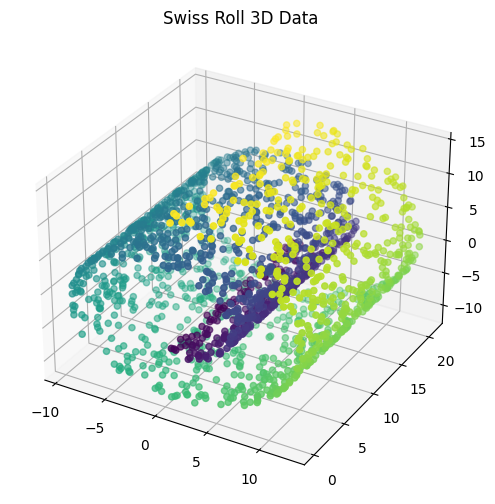

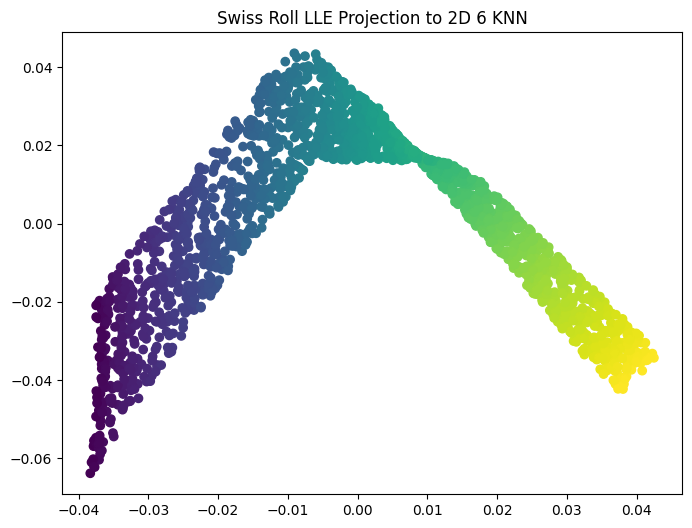

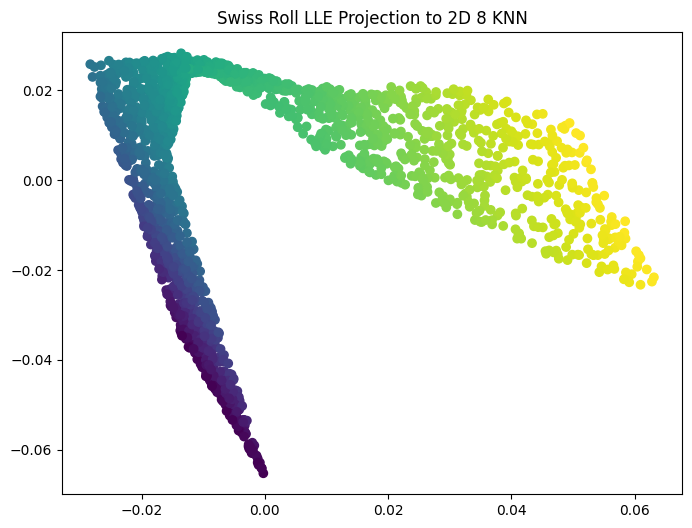

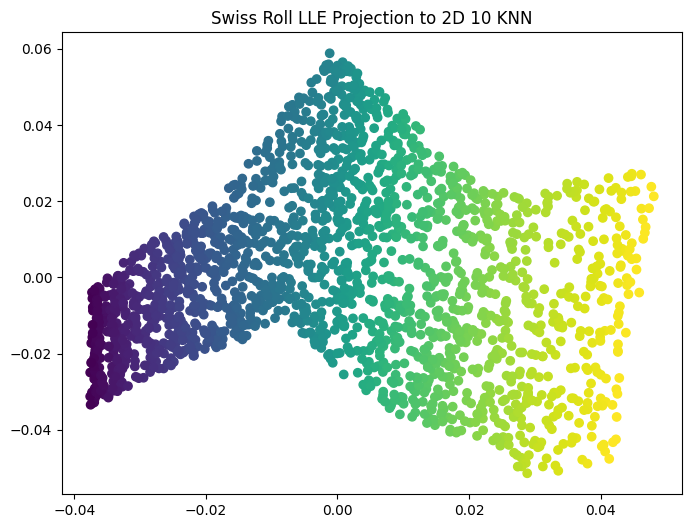

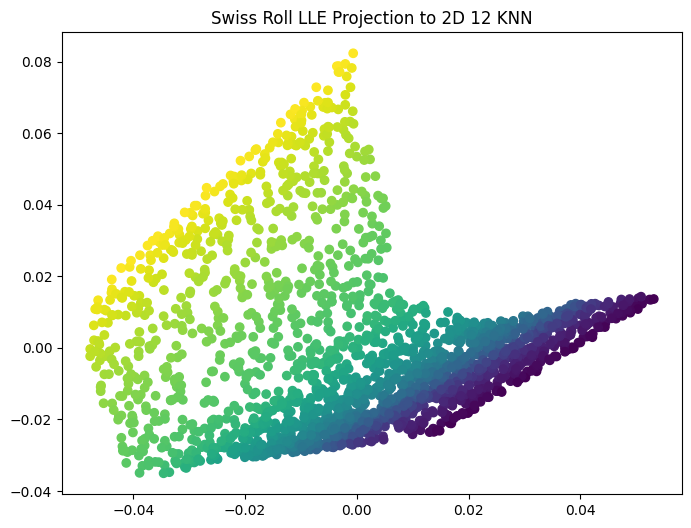

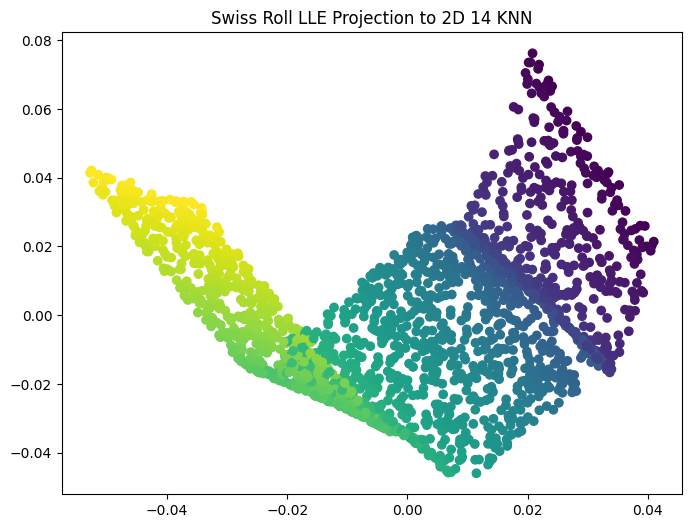

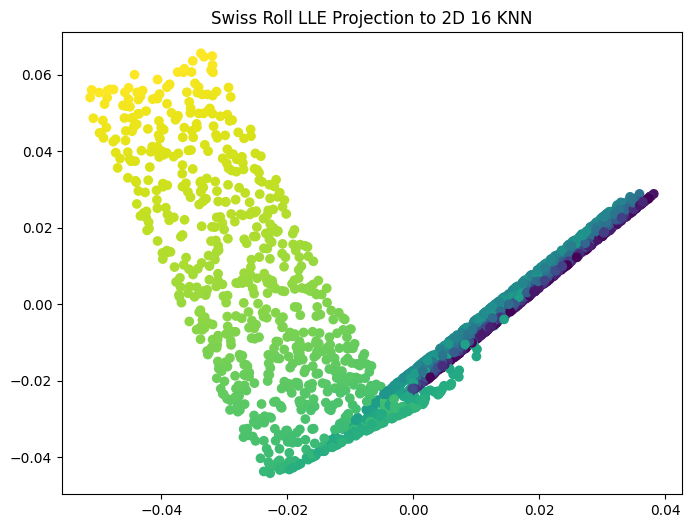

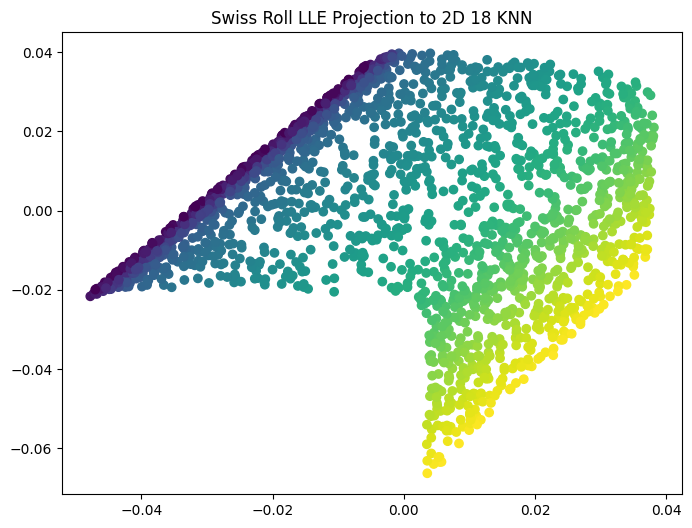

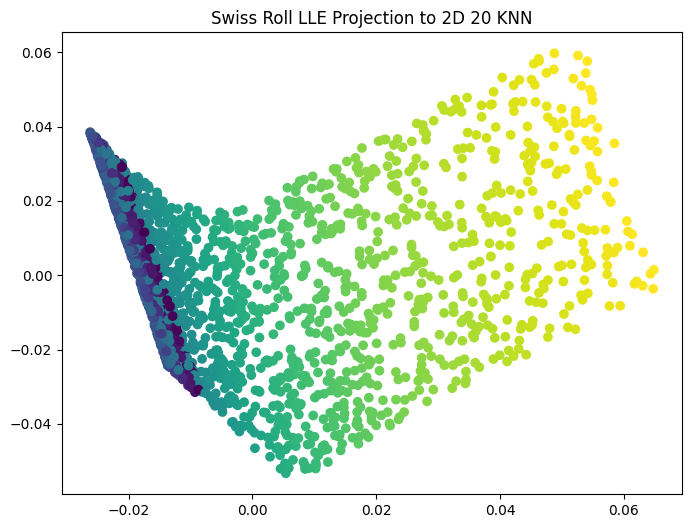

In [117]:
# ______________________________3.1. Compute local transformations______________________________

class LLE:
    def __init__(self, n_components, *, adj_calculator=KNearestNeighbors(20)):
        self.n_components = n_components
        self._adj_calculator = adj_calculator

    def _compute_weights(self, X):
        """Compute reconstruction weights for each point using constrained least squares"""
        m, d = X.shape
        neighbors_matrix = self._adj_calculator(X)
        W = np.zeros((m, m))

        for i in range(m):
            neighbors_idx = np.where(neighbors_matrix[i] > 0)[0]
            Z = X[neighbors_idx] - X[i]  # Calculate the distances
            C = Z @ Z.T  # create local covariance matrix
            C += np.eye(len(neighbors_idx)) * 1e-3 # Make it unsingular

            weights = np.linalg.solve(C, np.ones(len(neighbors_idx)))  # CW = 1
            weights /= np.sum(weights)  # normalize weights

            W[i, neighbors_idx] = weights

        return W

# ______________________________3.2. Find the embeddings______________________________

    def _compute_embedding(self, W):
        m = W.shape[0]
        M = (np.eye(m) - W).T @ (np.eye(m) - W)  # M = (I-W)^T * (I-W)

        eigenvalues, eigenvectors = np.linalg.eigh(M)
        return eigenvectors[:, 1:self.n_components + 1]  # Skip the first eigenvector cuz its always zero


    def fit_transform(self, X):
        W = self._compute_weights(X)
        return self._compute_embedding(W)


# ______________________________Extra: Apply to the swiss roll______________________________

if __name__ == "__main__":

    X, colors = load_dataset("datasets\swissroll.npz")

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=colors, cmap='viridis')
    plt.title("Swiss Roll 3D Data")
    plt.show()

    for i in range(5,21,2):
        lle = LLE(n_components=2, adj_calculator=KNearestNeighbors(i+1))
        X_lle = lle.fit_transform(X)

        plt.figure(figsize=(8, 6))
        plt.scatter(X_lle[:, 0], X_lle[:, 1], c=colors, cmap='viridis')
        plt.title(f"Swiss Roll LLE Projection to 2D {i+1} KNN")
        plt.show()

### metrics.py

``` math
T(k) = 1 - \frac{2}{n k (2n - 3k - 1)} \sum_{i=1}^{n} \sum_{j \in N_{i,k}} \max(0, (r(i, j) - k))
```

In [116]:
# ______________________________3.3. Implement the evaluation metrics______________________________


def trustworthiness(D, D_embedded, n_neighbors=20):
    n = D.shape[0]
    
    # Find the k nearest neighbors in the original space
    original_neighbors = np.argsort(D, axis=1)[:, 1:n_neighbors + 1]
    
    # Find the k nearest neighbors in the embedded space
    embedded_neighbors = np.argsort(D_embedded, axis=1)[:, 1:n_neighbors + 1]
    
    # Compute the rank of points in the embedded space
    rank_matrix = np.zeros((n, n))
    for i in range(n):
        sorted_indices = np.argsort(D_embedded[i])
        for rank, index in enumerate(sorted_indices):
            rank_matrix[i, index] = rank

    # Compute the penalty
    penalty = 0
    for i in range(n):
        for j in embedded_neighbors[i]:
            if j not in original_neighbors[i]:
                penalty += max(0, rank_matrix[i, j] - n_neighbors)

    normalization_factor = 2 / (n * n_neighbors * (2 * n - 3 * n_neighbors - 1))
    trustworthiness_score = 1 - normalization_factor * penalty
    
    return trustworthiness_score


##  5. Implementation of Laplacian Eigenmaps

### spectral.py

``` math
W_{ij} = \exp\left(\frac{-||x_i - x_j||^2}{2\sigma^2}\right)
```

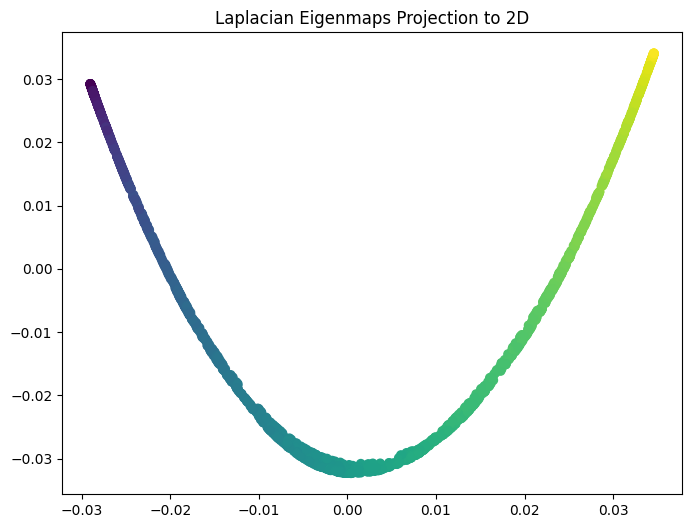

In [123]:
class LaplacianEigenmaps:
    def __init__(self, n_components, *, adj_calculator=KNearestNeighbors(20)):
        self.n_components = n_components
        self._adj_calculator = adj_calculator

    def _compute_weight_matrix(self, X):
        """Compute the weight matrix W using a Gaussian function."""
        adjacency_matrix = self._adj_calculator(X)
        sigma = np.mean(adjacency_matrix[adjacency_matrix > 0])  # Compute sigma
        W = np.exp(-adjacency_matrix ** 2 / (2 * sigma ** 2))
        W[adjacency_matrix == 0] = 0  # Assign weights only to neighbors
        return W

    def _compute_laplacian(self, W):
        """Compute the Laplacian matrix L = D - W."""
        D = np.diag(np.sum(W, axis=1))
        L = D - W
        return L

    def _compute_embedding(self, L):
        """Solve the eigenvalue problem and extract the smallest nonzero eigenvectors."""
        eigenvalues, eigenvectors = np.linalg.eigh(L)
        return eigenvectors[:, 1:self.n_components + 1]  # Ignore the first eigenvector (zero eigenvalue)

    def fit_transform(self, X):
        """Perform the complete Laplacian Eigenmaps algorithm."""
        W = self._compute_weight_matrix(X)
        L = self._compute_laplacian(W)
        return self._compute_embedding(L)


if __name__ == "__main__":

    # Load the Swiss Roll dataset
    X, colors = load_dataset("datasets/swissroll.npz")

    # Apply Laplacian Eigenmaps
    laplacian = LaplacianEigenmaps(n_components=2)
    X_laplacian = laplacian.fit_transform(X)

    # Display results
    plt.figure(figsize=(8, 6))
    plt.scatter(X_laplacian[:, 0], X_laplacian[:, 1], c=colors, cmap="viridis")
    plt.title("Laplacian Eigenmaps Projection to 2D")
    plt.show()


## 4. Learning the Manifold of Images
Compare The Algorithms

### main.py

In [101]:
if __name__ == "__main__":

# _________________________________Swiss Roll____________________________________

    X_swiss, colors = load_dataset("datasets/swissroll.npz")

    D_original_swiss = _compute_distance_matrix(X_swiss)

    # PCA
    pca = PCA(n_components=2)
    X_pca_swiss = pca.fit_transform(X_swiss)
    D_pca_swiss = _compute_distance_matrix(X_pca_swiss)
    t_pca_swiss = trustworthiness(D_original_swiss, D_pca_swiss)

    # Isomap
    isomap = Isomap(n_components=2)
    X_isomap_swiss = isomap.fit_transform(X_swiss)
    D_isomap_swiss = _compute_distance_matrix(X_isomap_swiss)
    t_isomap_swiss = trustworthiness(D_original_swiss, D_isomap_swiss)

    # LLE
    lle = LLE(n_components=2)
    X_lle_swiss = lle.fit_transform(X_swiss)
    D_lle_swiss = _compute_distance_matrix(X_lle_swiss)
    t_lle_swiss = trustworthiness(D_original_swiss, D_lle_swiss)

    # Laplacian Eigenmaps
    laplacian = LaplacianEigenmaps(n_components=2)
    X_laplacian_swiss = laplacian.fit_transform(X_swiss)
    D_laplacian_swiss = _compute_distance_matrix(X_laplacian_swiss)
    t_laplacian_swiss = trustworthiness(D_original_swiss, D_laplacian_swiss)

# _________________________________Faces____________________________________

    X_faces, _ = load_dataset("datasets/faces.npz")

    D_original_faces = _compute_distance_matrix(X_faces)

    # Isomap
    isomap_faces = Isomap(n_components=50)
    X_isomap_faces = isomap_faces.fit_transform(X_faces)
    D_isomap_faces = _compute_distance_matrix(X_isomap_faces)
    t_isomap_faces = trustworthiness(D_original_faces, D_isomap_faces)

    # LLE
    lle_faces = LLE(n_components=50)
    X_lle_faces = lle_faces.fit_transform(X_faces)
    D_lle_faces = _compute_distance_matrix(X_lle_faces)
    t_lle_faces = trustworthiness(D_original_faces, D_lle_faces)
    
    # Laplacian Eigenmaps
    laplacian = LaplacianEigenmaps(n_components=50)
    X_laplacian_faces = laplacian.fit_transform(X_faces)
    D_laplacian_faces = _compute_distance_matrix(X_laplacian_faces)
    t_laplacian_faces = trustworthiness(D_original_faces, D_laplacian_faces)


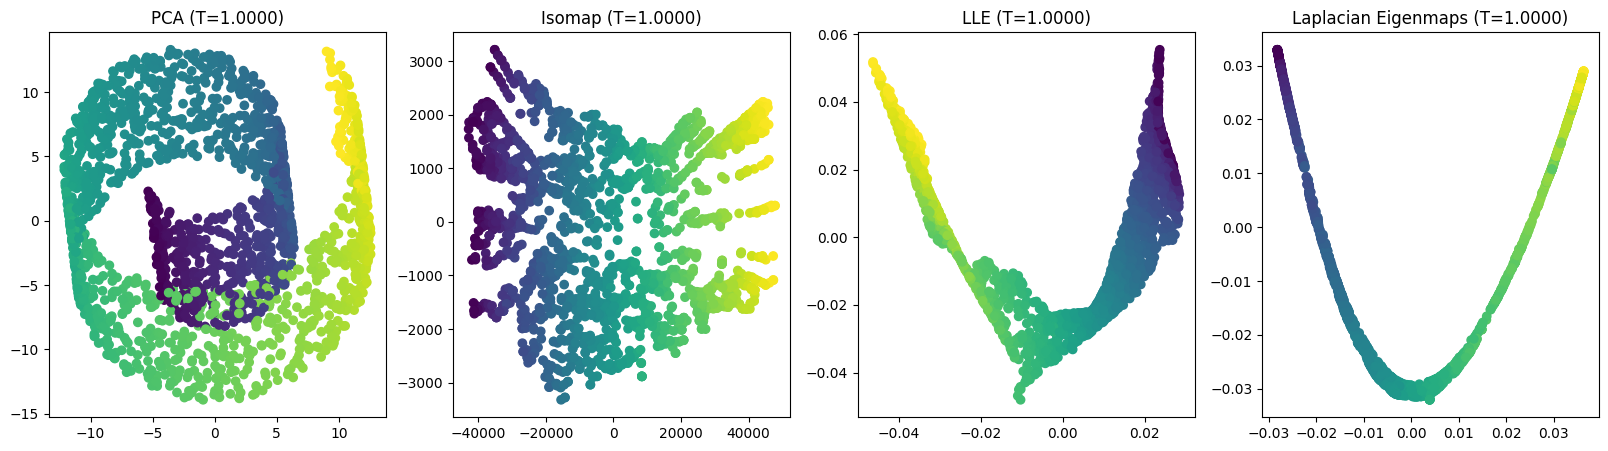

Trustworthiness - PCA (Faces - 10 components): 1.0000
Trustworthiness - PCA (Faces - 100 components): 1.0000
Trustworthiness - Isomap (Faces): 1.0000
Trustworthiness - LLE (Faces): 1.0000
Trustworthiness - Laplacian (Faces): 1.0000


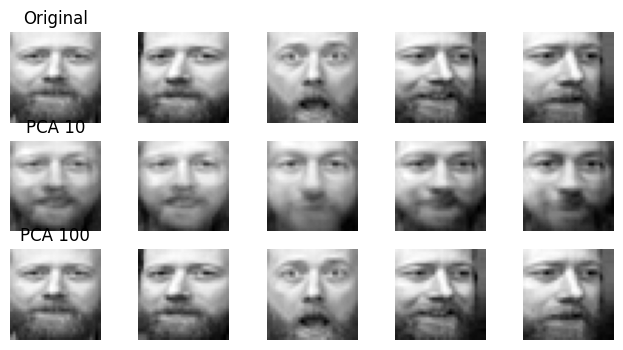

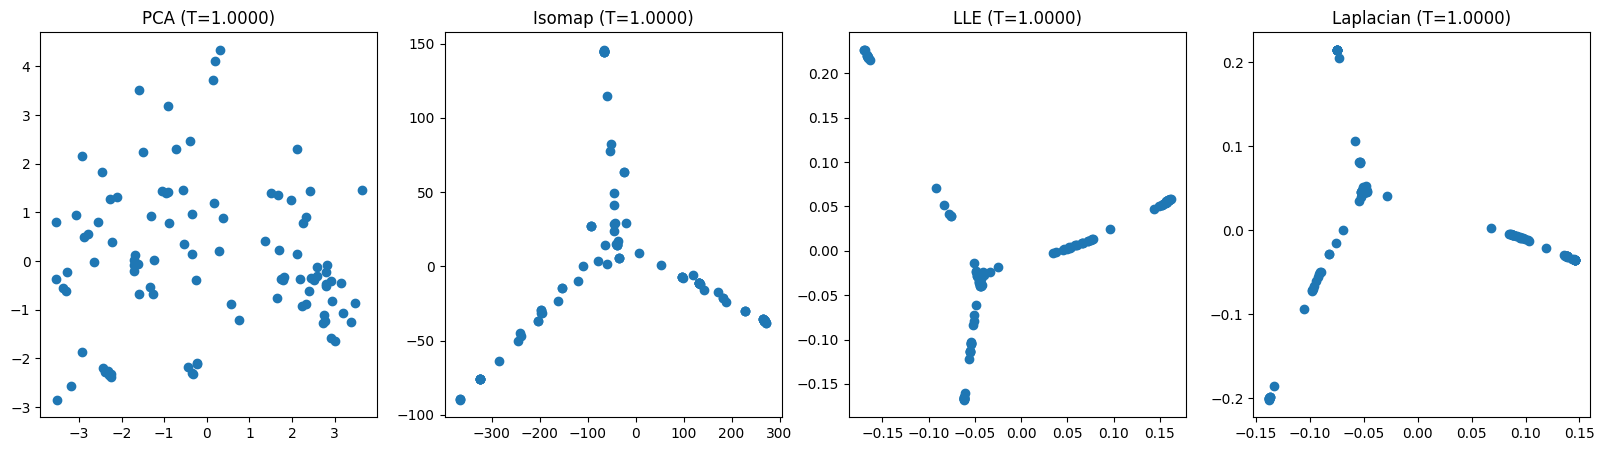

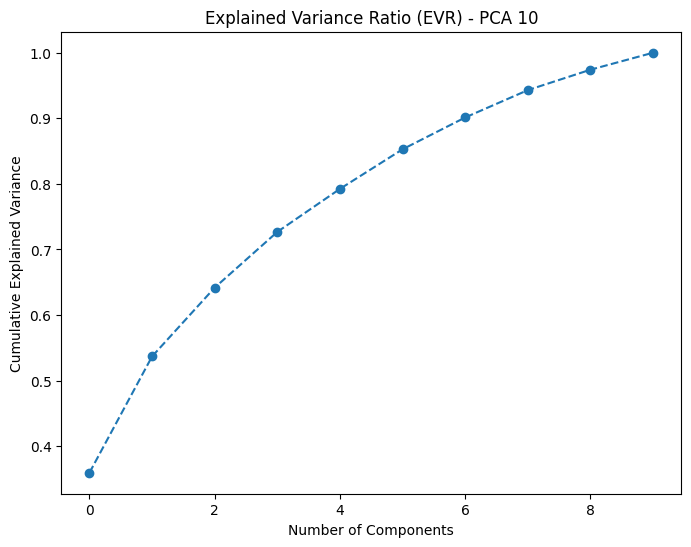

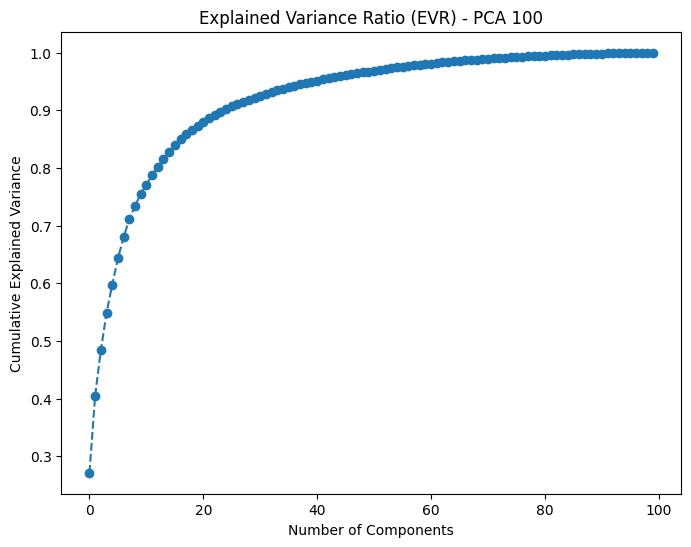

In [103]:
if __name__ == "__main__":

    # _____________________Swiss Roll_____________________

    # Reduced data in 2D
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].scatter(X_pca_swiss[:, 0], X_pca_swiss[:, 1], c=colors, cmap="viridis")
    axes[0].set_title(f"PCA (T={t_pca_swiss:.4f})")

    axes[1].scatter(X_isomap_swiss[:, 0], X_isomap_swiss[:, 1], c=colors, cmap="viridis")
    axes[1].set_title(f"Isomap (T={t_isomap_swiss:.4f})")

    axes[2].scatter(X_lle_swiss[:, 0], X_lle_swiss[:, 1], c=colors, cmap="viridis")
    axes[2].set_title(f"LLE (T={t_lle_swiss:.4f})")

    axes[3].scatter(X_laplacian_swiss[:, 0], X_laplacian_swiss[:, 1], c=colors, cmap="viridis")
    axes[3].set_title(f"Laplacian Eigenmaps (T={t_laplacian_swiss:.4f})")

    plt.show()

    # _____________________Faces_____________________

    # PCA with 10 components
    pca_faces_10 = PCA(n_components=10)
    X_pca_faces_10 = pca_faces_10.fit_transform(X_faces)
    D_pca_faces_10 = _compute_distance_matrix(X_pca_faces_10)
    t_pca_faces_10 = trustworthiness(D_original_faces, D_pca_faces_10)

    # PCA with 100 components
    pca_faces_100 = PCA(n_components=100)
    X_pca_faces_100 = pca_faces_100.fit_transform(X_faces)
    D_pca_faces_100 = _compute_distance_matrix(X_pca_faces_100)
    t_pca_faces_100 = trustworthiness(D_original_faces, D_pca_faces_100)

    # Reconstruct faces using PCA transformations
    X_faces_reconstructed_pca_10 = pca_faces_10.inverse_transform(X_pca_faces_10)
    X_faces_reconstructed_pca_100 = pca_faces_100.inverse_transform(X_pca_faces_100)

    # Display Trustworthiness scores
    print(f"Trustworthiness - PCA (Faces - 10 components): {t_pca_faces_10:.4f}")
    print(f"Trustworthiness - PCA (Faces - 100 components): {t_pca_faces_100:.4f}")
    print(f"Trustworthiness - Isomap (Faces): {t_isomap_faces:.4f}")
    print(f"Trustworthiness - LLE (Faces): {t_lle_faces:.4f}")
    print(f"Trustworthiness - Laplacian (Faces): {t_laplacian_faces:.4f}")

    # Original and reconstructed faces using PCA
    fig, axes = plt.subplots(3, 5, figsize=(8, 4))
    for i in range(5):
        axes[0, i].imshow(X_faces[i].reshape(32, 32), cmap="gray")
        axes[0, i].axis("off")
        axes[1, i].imshow(X_faces_reconstructed_pca_10[i].reshape(32, 32), cmap="gray")
        axes[1, i].axis("off")
        axes[2, i].imshow(X_faces_reconstructed_pca_100[i].reshape(32, 32), cmap="gray")
        axes[2, i].axis("off")

    axes[0, 0].set_title("Original")
    axes[1, 0].set_title("PCA 10")
    axes[2, 0].set_title("PCA 100")
    plt.show()

    # Reduced data in 2D for faces
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].scatter(X_pca_faces_100[:, 0], X_pca_faces_100[:, 1])
    axes[0].set_title(f"PCA (T={t_pca_faces_100:.4f})")

    axes[1].scatter(X_isomap_faces[:, 0], X_isomap_faces[:, 1])
    axes[1].set_title(f"Isomap (T={t_isomap_faces:.4f})")

    axes[2].scatter(X_lle_faces[:, 0], X_lle_faces[:, 1])
    axes[2].set_title(f"LLE (T={t_lle_faces:.4f})")

    axes[3].scatter(X_laplacian_faces[:, 0], X_laplacian_faces[:, 1])
    axes[3].set_title(f"Laplacian (T={t_lle_faces:.4f})")

    # Explained Variance Ratio (EVR)
    plt.figure(figsize=(8, 6))
    plt.plot(np.cumsum(pca_faces_10.explained_variance_ratio_), marker='o', linestyle='--')
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("Explained Variance Ratio (EVR) - PCA 10")
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(np.cumsum(pca_faces_100.explained_variance_ratio_), marker='o', linestyle='--')
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("Explained Variance Ratio (EVR) - PCA 100")
    plt.show()

    plt.show()
